# Facial Recognition

This was a project, part of my advanced topics in machine learning class. The task is to use a convolutional neural neural network for finding faces on images. 

# The Setup

## The Modules

Import the modules we will need

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import cv2
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import time
import seaborn as sns; sns.set_theme()
import sys
import matplotlib.patches as patches

cuda


We train on the GPU if possible.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Import the data

We connect to the google drive where the zip file is located.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Assignement2')

Mounted at /content/drive


We unzip the file and load it directly into ram for faster loading.

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Assignement2/Assignment2_data.zip" -d "/content"

The torchvision module will already do everything for us. We only need to 
specify the folder which containts the different image folders and it will automatically assign a class (0 for not face and 1 for face). We use a data loader where we shuffle the data and create batches of size 64.

In [ ]:
#we transform the pictures into tensors and normalize the pictures
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#the training dataset
train_dataset = ImageFolder(root= "/content/train/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#the validation datasetx
valid_dataset = ImageFolder(root= "/content/val/", transform=transform)
valid_loader = DataLoader(valid_dataset, shuffle=True)

## A peek at the data

Let's look at a few examples from both set....

In [ ]:
def showDatasetExamples(dataset, name, n):
  fig, axs = plt.subplots(1, n)
  fig.suptitle(name)
  fig.set_figwidth(30)
  fig.tight_layout()
  
  for i in range(n):
    #get a random example
    example = random.choice(dataset)
    img = np.transpose(example[0], (1, 2, 0))
    axs[i].imshow(img)
    axs[i].axis('off')
    if example[1] == 0:
      axs[i].title.set_text("Not Face")
    else:
      axs[i].title.set_text("Face")

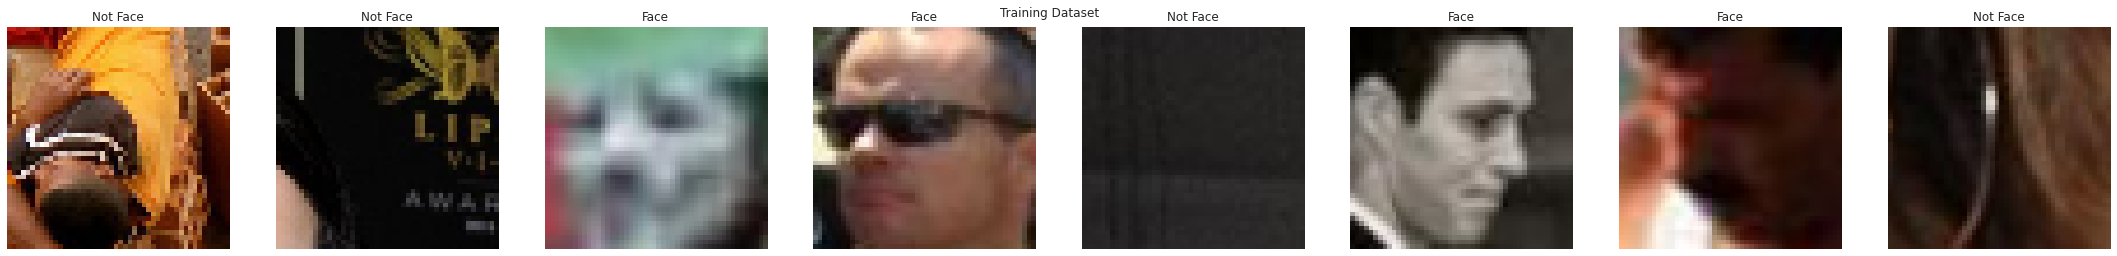

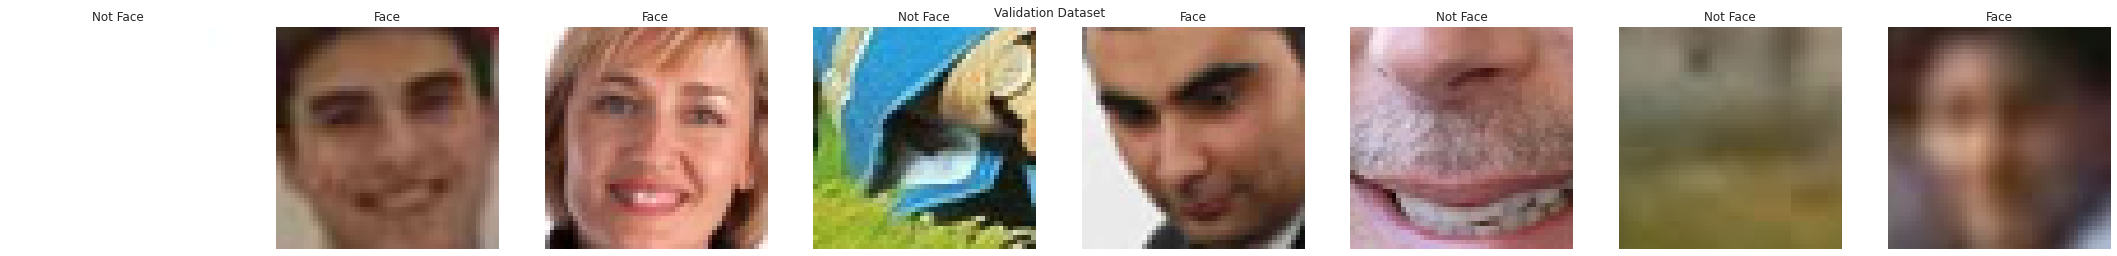

In [ ]:
showDatasetExamples(train_dataset, "Training Dataset", 8)
showDatasetExamples(valid_dataset, "Validation Dataset", 8)

# The convolutional binary classifier

## Initialization

This will be our base model.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, kernel_size=(3, 3), stride=1, out_channels=32)
      self.maxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, ceil_mode=True)

      self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

      self.conv3 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(in_channels=64, kernel_size=(2, 2), stride=1, out_channels=128)
      self.conv5 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), stride=1, out_channels=256)
      self.conv6 = nn.Conv2d(in_channels=256, kernel_size=(1, 1), stride=1, out_channels=2)

    def forward(self, x):
      x = F.leaky_relu(self.maxPool1(self.conv1(x)), 0.2)
      x = F.leaky_relu(self.maxPool2(self.conv2(x)), 0.2)
      x = F.leaky_relu(self.maxPool3(self.conv3(x)), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = F.leaky_relu(self.conv5(x), 0.2)
      x = self.conv6(x)

      return x

In [ ]:
cnn = CNN()
cnn.loss_function = nn.CrossEntropyLoss()
cnn.optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0003)
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (loss_function): CrossEntropyLoss()
)

## Define the helper functions



The accuracy will be given as number of correct predictions divided by the total number of predictions. So it's a value between 0 and 1.

In [ ]:
def get_accuracy(labels, predictions):
  accuracy = (predictions == labels).sum().item() / len(labels)
  return accuracy

The evaluate_model function calculates the performance of the model on a dataset, and returns loss and accuracy on that set.

In [ ]:
def evaluate_model(model, dataset):
    model.eval()
    accuracy = 0
    losses = 0
    count = 0

    with torch.no_grad():
        for i, input in enumerate(dataset):

          #inputs = (image, label)
          image = input[0].to(device)
          label = input[1].to(device)

          #get prediction
          prediction = model(image)
          prediction = prediction.reshape(len(prediction), 2)

          #accuracy
          predicted_label = prediction.argmax(dim=1)
          accuracy += get_accuracy(label, predicted_label)

          #loss
          loss = model.loss_function(prediction, label)
          losses += loss
          
          count += 1
        

    #average out
    avg_loss = losses / count
    accuracy = 100 * (accuracy / count)

    return avg_loss, accuracy

The train_model function works in similar fashion as the evaluation function but adds the backpropagation to improve the model.

In [ ]:
def train_model(model, train_loader):
    model.train()
    accuracy = 0
    losses = 0
    count = 0

    for i, input in enumerate(train_loader):

      #inputs = (images, labels)
      images = input[0].to(device)
      labels = input[1].to(device)

      #get prediction
      predictions = model(images)
      predictions = predictions.reshape(len(predictions), 2)

      #accuracy
      predicted_labels = predictions.argmax(dim=1)
      accuracy += get_accuracy(labels, predicted_labels)

      #loss
      loss = model.loss_function(predictions, labels)
      losses += loss.item()

      #backpropagation
      model.optimizer.zero_grad()
      loss.backward()
      model.optimizer.step()

      if i % 100 == 0:
        print("  - " + str(i))
      count += 1


    #average out
    avg_loss = losses / count
    accuracy = 100 * (accuracy / count)

    return avg_loss, accuracy

For each epoch, the run function trains the model on the training dataset and tracks the accuracy on the training set. 

In [ ]:
def run(model, train_loader, valid_loader, num_epochs):
  training_losses = []
  validation_losses = []
  training_accuracies = []
  validation_accuracies = []

  print("__Start__\n")
  t0 = time.time()

  for epoch in range(num_epochs):
    print("Epoch " + str(epoch))

    #training
    print(" * training")
    training_loss, training_accuracy = train_model(model, train_loader)

    #validation
    print(" * validation\n")
    validation_loss, validation_accuracy = evaluate_model(model, valid_loader)

    #lists
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    training_accuracies.append(training_accuracy)
    validation_accuracies.append(validation_accuracy)


  print("\n runtime : " + str(int(time.time() - t0)) + "s\n")
  print("__Finished__\n")
  return training_losses, validation_losses, training_accuracies, validation_accuracies

## Training the convolutional model

We will the train the model on the whole dataset for 10 epoch.

In [ ]:
training_losses_cnn, validation_losses_cnn, training_accuracies_cnn, validation_accuracies_cnn = run(cnn, train_loader, valid_loader, 10)

Let's plot the losses and accuracy on both the training and validation set.

In [ ]:
def plot_loss_accuracy(training_losses, validation_losses, training_accuracies, validation_accuracies):
    fig, ax = plt.subplots()
    ax.plot(training_losses, label="training")
    ax.plot(validation_losses, label="validation")
    ax.legend()
    ax.set_title("Losses")

    fig, ax = plt.subplots()
    ax.plot(training_accuracies, label="training")
    ax.plot(validation_accuracies, label="validation")
    ax.legend()
    ax.set_title("Accuracy")

    plt.show()

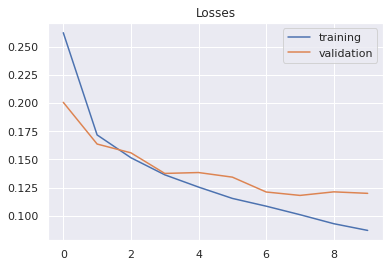

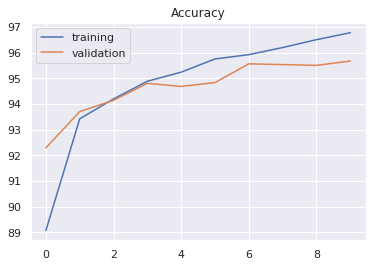

In [ ]:
plot_loss_accuracy(training_losses_cnn, validation_losses_cnn, training_accuracies_cnn, validation_accuracies_cnn)

## Saving/Loading the model

In [ ]:
#saving our model
path = F"/cnn.pt" 
torch.save(cnn.state_dict(), path)

In [ ]:
#load our model
path = F"/content/drive/MyDrive/Colab Notebooks/Assignement2/cnn.pt"
cnn.load_state_dict(torch.load(path))

<All keys matched successfully>

# The face detector

## Initialization

In [ ]:
from bounding_box import nms #helper file

The detect_single_scale function will take a large image and run the model on it. It calculates a matrix of probabilities where it's most likely to be a face. We use a threshold to return the location with highest probabilities.

The detect_multi_scale function takes an image as well, but it will run the detect_single_scale function with the image scaled at different scale factors and thus get a lot of different locations. The module nms will join the bounding boxses and return a list of locations.

In [ ]:
class FullyConvolutionalDetector:
    def __init__(self, model, max_res=1024, scales=[1.0, 0.8, 0.6, 0.4, 0.2, 0.1], threshold=0.5):
        self.model = model
        self.max_res = max_res
        self.scales = scales
        self.threshold = threshold
    
    @torch.no_grad()
    def detect_single_scale(self, image, return_map=False):
        ## the image is a tensor of shape 1x3xHxW
        L, D, H, W = image.shape
        image = image.to(device)

        ## we run the model on the image
        prediction = self.model(image)

        ## we process the output
        softmax = nn.Softmax(dim=1)
        prediction = softmax(prediction)

        ## we want the probability of each square being a face
        probabilities = prediction[0][1].cpu().detach().numpy()
        h, w = probabilities.shape
        
        ## we find output coordinates where the face probability > self.threshold
        ys, xs = np.where(probabilities > self.threshold)

        ## the selected output coordinates are converted into input coordinates 
        sw, sh = W / w, H / h # scaling factor
        
        face_coordinates = []
        face_probabilities = []
        for i in range(len(xs)):
          #get the position and probability
          x, y = xs[i], ys[i]
          p = probabilities[y][x]

          #convert to input size
          x1, y1 = max(0, (x * sw) - 24), max(0, (y * sh) - 24) #minimum: 0
          x2, y2 = min(W, x1 + 48), min(H, y1 + 48) #maximum: width, height
          x1, y1 = x2 - 48, y2 - 48 #to reajust 

          #append to the list
          face_coordinates.append([x1, y1, x2, y2])
          face_probabilities.append(p)

        #return face_coordinates, face_probabilities
        if return_map:
          return np.array(face_coordinates), np.array(face_probabilities), probabilities
        else:
          return np.array(face_coordinates), np.array(face_probabilities)
    

    @torch.no_grad()
    def detect_multi_scale(self, image, use_nms=True):
        '''Run the detector on a pyramid of images (same image in different scales)'''
        all_face_coordinates = np.empty(shape=[0, 4])
        all_face_probabilities = np.array([])
        
        #image has a shape 1x3xHxW
        L, C, H, W = image.shape

        for scale in self.scales:
            ## the image is scaled by a scale factor
            scaled_image = nn.functional.interpolate(image, scale_factor=scale, recompute_scale_factor=False)

            ## we run detect_single_scale on resized image
            face_coordinates, face_probabilities = self.detect_single_scale(scaled_image)
            
            ## we scale back the returned face coordinates to original image coordinates
            face_coordinates = face_coordinates / scale

            ## and append the results to the rest
            if len(face_probabilities) != 0:
              all_face_coordinates = np.concatenate((all_face_coordinates, face_coordinates))
              all_face_probabilities = np.concatenate((all_face_probabilities, face_probabilities))
        
        if use_nms == True and len(all_face_coordinates) > 0:
            # merge overlapping predictions
            results = np.concatenate((all_face_coordinates, all_face_probabilities.reshape(-1,1)),1)
            results = nms(results, 0.3) 
            all_face_coordinates = results[:,:4]
            all_face_probabilities = results[:,4]

        #return face_coordinates, face_probabilities
        return all_face_coordinates, all_face_probabilities

Let's define two helper function, one to get the images and one for drawing.

In [ ]:
def read_images(img_dir, box_dir):
    #get the images and face bounding boxes coordinates
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    box_files = [os.path.join(box_dir, f.replace('.jpg','.txt')) for f in img_files]
    img_files = [os.path.join(img_dir, f) for f in img_files]
    images = [torch.Tensor([np.transpose((np.array(Image.open(f)).astype(np.float32)/255), (2, 0, 1))]) for f in img_files]
    boxes = [np.loadtxt(f, ndmin=2).astype(np.int32) for f in box_files]

    return images, boxes

In [ ]:
def draw_boxes_with_gt(image, boxes, gt_boxes=None):
    img_draw = np.array(np.transpose(image[0], (1, 2, 0)))

    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [10, 5]
    ax.axis('off')
    ax.imshow(img_draw)
    
    #the predicted rectangles
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    #the correct rectangles
    if gt_boxes is not None:
        for box in gt_boxes:
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
    plt.show()

Now let's run the model on our full images.

In [ ]:
images, boxes = read_images("/content/full_images/", "/content/full_boxes/")

We initialize our face detector and set a threshold, basically a confidence level when we can recognize it as a face.

In [ ]:
detector = FullyConvolutionalDetector(cnn, threshold=0.9999)

## Single Scale

Let's look at what the model sees for a single scale. 

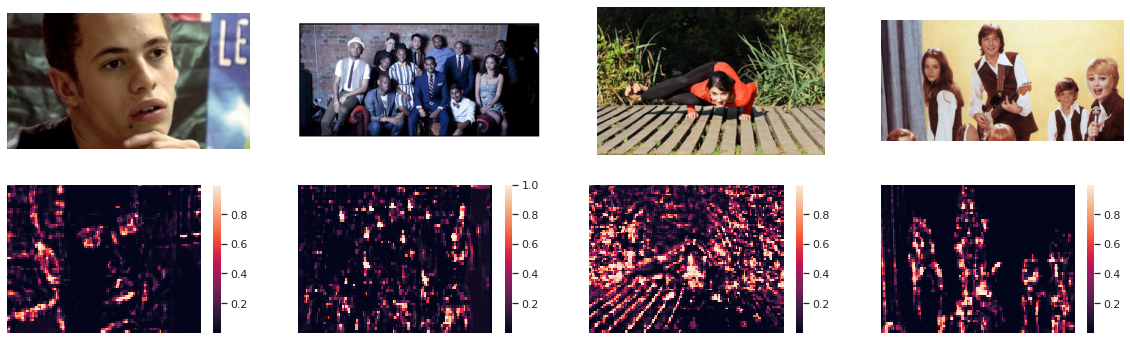

In [ ]:
fig, ax = plt.subplots(2, len(images), figsize=(20, 6))

for i in range(len(images)):
    #get probabilities
    all_face_coordinates, all_face_probabilities, map = detector.detect_single_scale(images[i], return_map=True)
    
    #draw
    img_draw = np.array(np.transpose(images[i][0], (1, 2, 0)))
    ax[0][i].imshow(img_draw)
    ax[0][i].axis('off')
    sns.heatmap(map, ax=ax[1][i])
    ax[1][i].axis('off')

The brighter the color, the higher the predicted probability of being a face.

## Without the suppression algorithm (nms=False)

Now let the model find the faces. The green boxes shows where the faces are, and the red where the model predicted there would be faces.

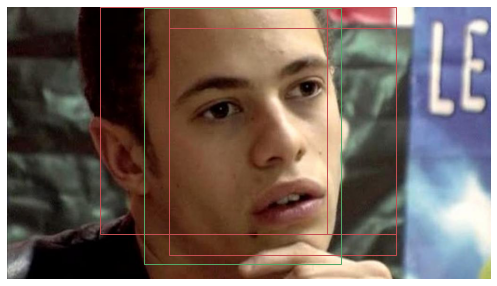

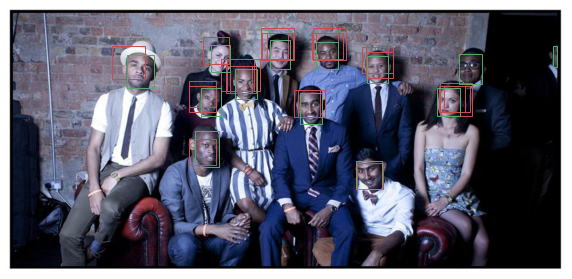

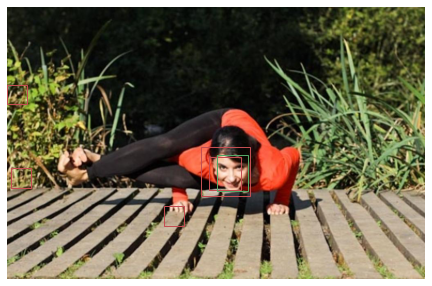

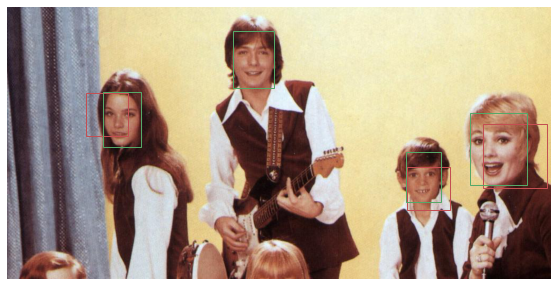

In [ ]:
for i in range(len(images)):
    all_face_coordinates, all_face_probabilities = detector.detect_multi_scale(images[i], use_nms=False)
    draw_boxes_with_gt(images[i], all_face_coordinates, boxes[i])

## With the suppression algorithm (nms=True)

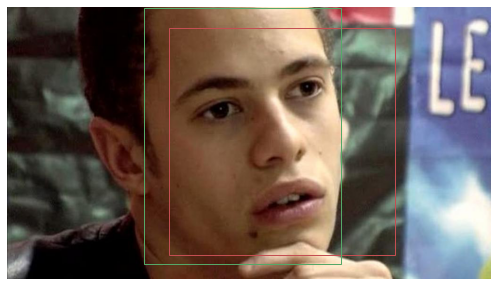

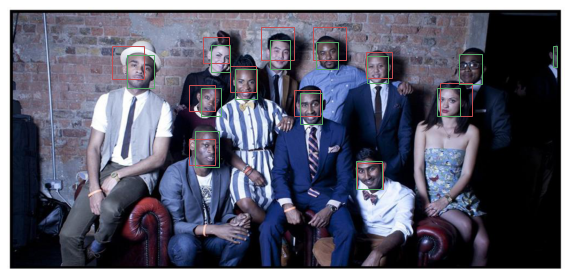

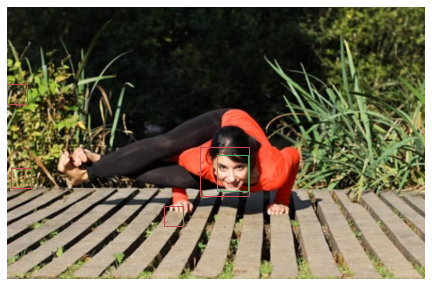

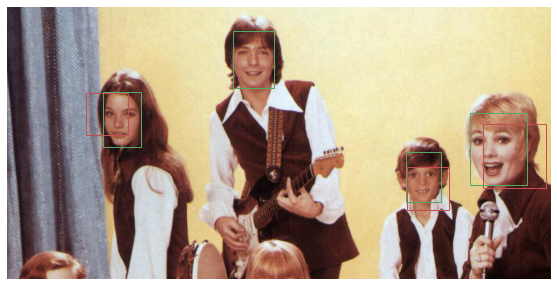

In [ ]:
for i in range(len(images)):
    all_face_coordinates, all_face_probabilities = detector.detect_multi_scale(images[i], use_nms=True)
    draw_boxes_with_gt(images[i], all_face_coordinates, boxes[i])

We see that the model performs surpisingly well, but is sometimes a bit trigger happy. The problem is when setting the threshold higher, it won't detect all the faces. So it's a tradeoff between detecting too much faces, and too few.

# Improving the base model

We will try to improve the model, with 5 different approaches.

## Model1

*Hypothesis:* a higher learning rate, using momentum with SGD will make the model converge faster

In [ ]:
class Model1(nn.Module):
    def __init__(self):
      super(Model1, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, kernel_size=(3, 3), stride=1, out_channels=32)
      self.maxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, ceil_mode=True)

      self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

      self.conv3 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(in_channels=64, kernel_size=(2, 2), stride=1, out_channels=128)
      self.conv5 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), stride=1, out_channels=256)
      self.conv6 = nn.Conv2d(in_channels=256, kernel_size=(1, 1), stride=1, out_channels=2)

    def forward(self, x):
      x = F.leaky_relu(self.maxPool1(self.conv1(x)), 0.2)
      x = F.leaky_relu(self.maxPool2(self.conv2(x)), 0.2)
      x = F.leaky_relu(self.maxPool3(self.conv3(x)), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = F.leaky_relu(self.conv5(x), 0.2)
      x = self.conv6(x)

      return x

model1 = Model1()
model1.loss_function = nn.CrossEntropyLoss()
model1.optimizer = torch.optim.SGD(model1.parameters(), lr=0.05, momentum=0.9)
model1.to(device)

Model1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (loss_function): CrossEntropyLoss()
)

In [ ]:
training_losses1, validation_losses1, training_accuracies1, validation_accuracies1 = run(model1, train_loader, valid_loader, 10)

*The changes*
*   using SGD instead of ADAM
*   changing the learning rate
*   adding momentum



In [ ]:
print('Training accuracy: {:.3f}%, Validation accuracy: {:.3f}%'.format(training_accuracies1[-1], validation_accuracies1[-1]))

Training accuracy: 96.047%, Validation accuracy: 95.000%


## Model2

*Hypothesis:* more channels will allow the model to find more patterns and thus give a higher accuracy

In [ ]:
class Model2(nn.Module):
    def __init__(self):
      super(Model2, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, kernel_size=(3, 3), stride=1, out_channels=32)
      self.maxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, ceil_mode=True)

      self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), stride=1, out_channels=96)
      self.maxPool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

      self.conv3 = nn.Conv2d(in_channels=96, kernel_size=(3, 3), stride=1, out_channels=96)
      self.maxPool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(in_channels=96, kernel_size=(2, 2), stride=1, out_channels=192)
      self.conv5 = nn.Conv2d(in_channels=192, kernel_size=(3, 3), stride=1, out_channels=384)
      self.conv6 = nn.Conv2d(in_channels=384, kernel_size=(1, 1), stride=1, out_channels=2)

    def forward(self, x):
      x = F.leaky_relu(self.maxPool1(self.conv1(x)), 0.2)
      x = F.leaky_relu(self.maxPool2(self.conv2(x)), 0.2)
      x = F.leaky_relu(self.maxPool3(self.conv3(x)), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = F.leaky_relu(self.conv5(x), 0.2)
      x = self.conv6(x)

      return x

model2 = Model2()
model2.loss_function = nn.CrossEntropyLoss()
model2.optimizer = torch.optim.Adam(model2.parameters(), lr=0.0003)
model2.to(device)

Model2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(96, 192, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(384, 2, kernel_size=(1, 1), stride=(1, 1))
  (loss_function): CrossEntropyLoss()
)

In [ ]:
training_losses2, validation_losses2, training_accuracies2, validation_accuracies2 = run(model2, train_loader, valid_loader, 10)

*The changes*
*   changing the output channel in conv2 to 96
*   changing the output channel in conv3 to 96
*   changing the output channel in conv4 to 192
*   changing the output channel in conv5 to 384

In [ ]:
print('Training accuracy: {:.3f}%, Validation accuracy: {:.3f}%'.format(training_accuracies2[-1], validation_accuracies2[-1]))

Training accuracy: 97.281%, Validation accuracy: 95.150%


## Model3

*Hypothesis:* bigger kernel size may give more context and thus lead to better results

In [ ]:
class Model3(nn.Module):
    def __init__(self):
      super(Model3, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, kernel_size=(5, 5), stride=1, padding=1, out_channels=32)
      self.maxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, ceil_mode=True)

      self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(5, 5), stride=1, padding=1, out_channels=64)
      self.maxPool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

      self.conv3 = nn.Conv2d(in_channels=64, kernel_size=(5, 5), stride=1, padding=1, out_channels=64)
      self.maxPool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(in_channels=64, kernel_size=(2, 2), stride=1, out_channels=128)
      self.conv5 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), stride=1, out_channels=256)
      self.conv6 = nn.Conv2d(in_channels=256, kernel_size=(1, 1), stride=1, out_channels=2)

    def forward(self, x):
      x = F.leaky_relu(self.maxPool1(self.conv1(x)), 0.2)
      x = F.leaky_relu(self.maxPool2(self.conv2(x)), 0.2)
      x = F.leaky_relu(self.maxPool3(self.conv3(x)), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = F.leaky_relu(self.conv5(x), 0.2)
      x = self.conv6(x)

      return x

model3 = Model3()
model3.loss_function = nn.CrossEntropyLoss()
model3.optimizer = torch.optim.Adam(model3.parameters(), lr=0.0004)
model3.to(device)

Model3(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (loss_function): CrossEntropyLoss()
)

In [ ]:
training_losses3, validation_losses3, training_accuracies3, validation_accuracies3 = run(model3, train_loader, valid_loader, 10)

*The changes*
*   changing the kernel size to (5,5) and adding padding in conv1, conv2, conv3
*   changing the learning rate to 0.0004

In [ ]:
print('Training accuracy: {:.3f}%, Validation accuracy: {:.3f}%'.format(training_accuracies3[-1], validation_accuracies3[-1]))

Training accuracy: 97.801%, Validation accuracy: 95.690%


## Model4

*Hypothesis:* a smaller batch size lead to longer computation time but better results

In [ ]:
class Model4(nn.Module):
    def __init__(self):
      super(Model4, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, kernel_size=(3, 3), stride=1, out_channels=32)
      self.maxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, ceil_mode=True)

      self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

      self.conv3 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(in_channels=64, kernel_size=(2, 2), stride=1, out_channels=128)
      self.conv5 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), stride=1, out_channels=256)
      self.conv6 = nn.Conv2d(in_channels=256, kernel_size=(1, 1), stride=1, out_channels=2)

    def forward(self, x):
      x = F.leaky_relu(self.maxPool1(self.conv1(x)), 0.2)
      x = F.leaky_relu(self.maxPool2(self.conv2(x)), 0.2)
      x = F.leaky_relu(self.maxPool3(self.conv3(x)), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = torch.sigmoid(self.conv5(x))
      x = self.conv6(x)

      return x


model4 = Model4()
model4.loss_function = nn.CrossEntropyLoss()
model4.optimizer = torch.optim.Adam(model4.parameters(), lr=0.0002)
model4.to(device)

Model4(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (loss_function): CrossEntropyLoss()
)

In [ ]:
train_loader_16 = DataLoader(train_dataset, batch_size=16, shuffle=True)
training_losses4, validation_losses4, training_accuracies4, validation_accuracies4 = run(model4, train_loader_16, valid_loader, 10)

*The changes*
*   changed learning rate to 0.0002
*   changed batch size to 16
*   changed activation function in last layer to sigmoid


In [ ]:
print('Training accuracy: {:.3f}%, Validation accuracy: {:.3f}%'.format(training_accuracies4[-1], validation_accuracies4[-1]))

Training accuracy: 96.727%, Validation accuracy: 95.510%


## Model5

*Hypothesis:* The more layers, the better

In [ ]:
class Model5(nn.Module):
    def __init__(self):
      super(Model5, self).__init__()

      self.conv1_1 = nn.Conv2d(in_channels=3, kernel_size=(3, 3), stride=1, padding=1, out_channels=32)
      self.conv1_2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), stride=1, out_channels=32)
      self.maxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, ceil_mode=True)

      self.conv2_1 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), stride=1, padding=1, out_channels=64)
      self.conv2_2 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

      self.conv3_1 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), stride=1, padding=1, out_channels=64)
      self.conv3_2 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), stride=1, out_channels=64)
      self.maxPool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

      self.conv4 = nn.Conv2d(in_channels=64, kernel_size=(2, 2), stride=1, out_channels=128)
      self.conv5 = nn.Conv2d(in_channels=128, kernel_size=(3, 3), stride=1, out_channels=256)
      self.conv6 = nn.Conv2d(in_channels=256, kernel_size=(1, 1), stride=1, out_channels=2)

    def forward(self, x):
      x = F.leaky_relu(self.maxPool1(self.conv1_2(self.conv1_1(x))), 0.2)
      x = F.leaky_relu(self.maxPool2(self.conv2_2(self.conv2_1(x))), 0.2)
      x = F.leaky_relu(self.maxPool3(self.conv3_2(self.conv3_1(x))), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = F.leaky_relu(self.conv5(x), 0.2)
      x = self.conv6(x)

      return x


model5 = Model5()
model5.loss_function = nn.CrossEntropyLoss()
model5.optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001)
model5.to(device)

Model5(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  (loss_function): CrossEntropyLoss()
)

In [ ]:
training_losses5, validation_losses5, training_accuracies5, validation_accuracies5 = run(model5, train_loader, valid_loader, 10)

*The changes*
*   added conv1_2
*   added conv2_2
*   added conv2_3
*   changed learning rate to 0.0001


In [ ]:
print('Training accuracy: {:.3f}%, Validation accuracy: {:.3f}%'.format(training_accuracies5[-1], validation_accuracies5[-1]))

Training accuracy: 96.163%, Validation accuracy: 95.150%


## Which is the best model?

In [ ]:
def plot_comparison(title, labels, datas):
    fig, ax = plt.subplots()

    for i in range(len(labels)):
      ax.plot(datas[i], label=labels[i])
    
    ax.legend()
    ax.set_title(title)

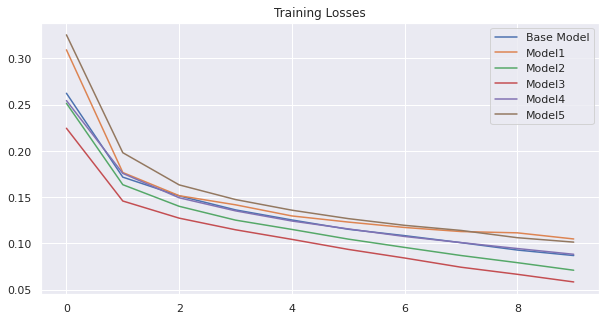

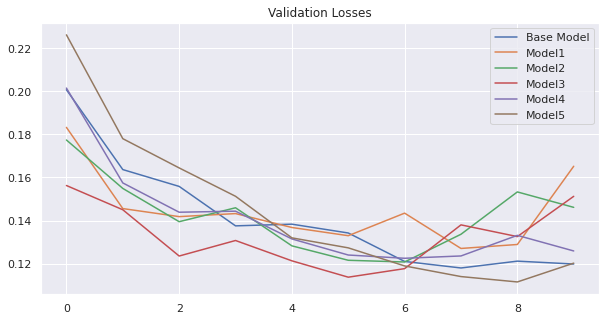

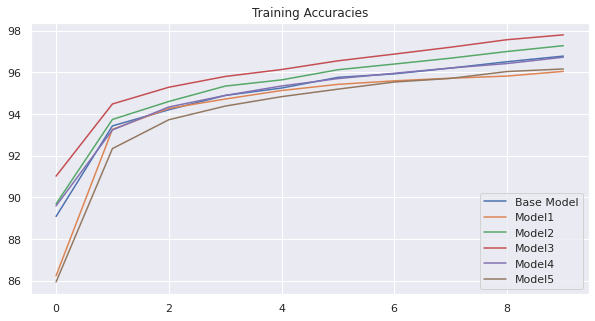

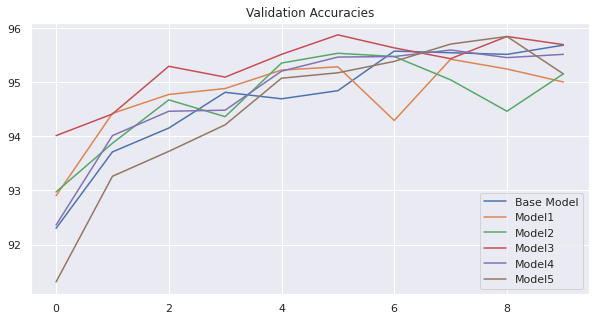

In [ ]:
labels = ["Base Model","Model1", "Model2", "Model3", "Model4", "Model5"]
training_losses = [training_losses_cnn, training_losses1, training_losses2, training_losses3, training_losses4, training_losses5]
validation_losses = [validation_losses_cnn, validation_losses1, validation_losses2, validation_losses3, validation_losses4, validation_losses5]
training_accuracies = [training_accuracies_cnn, training_accuracies1, training_accuracies2, training_accuracies3, training_accuracies4, training_accuracies5]
validation_accuracies = [validation_accuracies_cnn, validation_accuracies1, validation_accuracies2, validation_accuracies3, validation_accuracies4, validation_accuracies5]

plot_comparison("Training Losses", labels, training_losses)
plot_comparison("Validation Losses", labels, validation_losses)
plot_comparison("Training Accuracies", labels, training_accuracies)
plot_comparison("Validation Accuracies", labels, validation_accuracies)

Despite a lot of different configurations the models seem to perform very closely on the validation set. The reason might be that it's just very hard to get any higher because of the validation dataset. On the accuracy, Model3 seems to be the best; so we will use it to run on the full scale images.

## Run the best model on the full images

In [ ]:
best_detector = FullyConvolutionalDetector(model3, threshold=0.9999999)

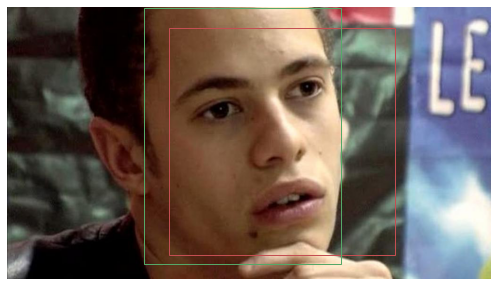

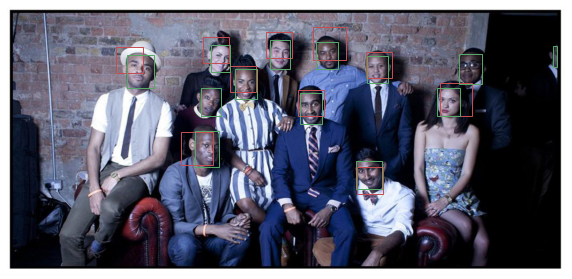

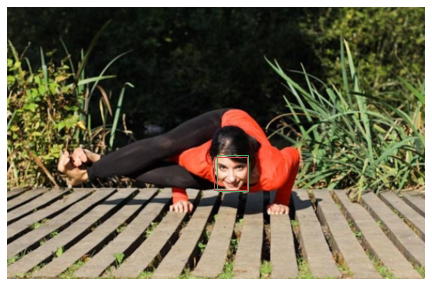

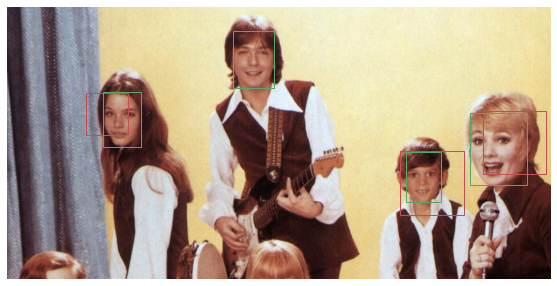

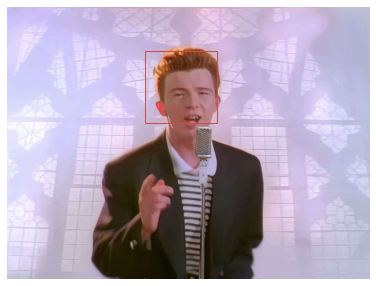

In [ ]:
#run it on the 4 given images + an image I have added
for i in range(len(images)):
    all_face_coordinates, all_face_probabilities = best_detector.detect_multi_scale(images[i], use_nms=True)
    draw_boxes_with_gt(images[i], all_face_coordinates, boxes[i])

We see pretty great results, the threshold is very sensible though.